In [1]:
import sys,os,time,cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from th_utils import *
from utils import imread_to_rgb, crop_img, emo2txt
import matplotlib.pyplot as plt


In [2]:
class Emotion_dataset(Dataset):
    def __init__(self, ops):
        self.ops = ops
        self.af_dict = self.ops.af_dict
        self.raf_dict = self.ops.raf_dict
        self.len = ops.iter_step*ops.batch_size #287401
    
    def __len__(self):
        return self.len
    
    
    def get_af(self):
        af_dict = self.af_dict
        
        # randomly choose emotion - wrt neutral probability
        rndv = th_rand()
        if rndv < ops.neutral_ratio:
            # neutral
            emo = 6
        else:
            # non neutral, choose again from 0~5
            emo = th_randint(0, 6)
        
        # label vec
        batch_emo = np.zeros(7)
        batch_emo[emo] = 1.
        
        # randomly choose image sample and import
        rndi = th_randint(len(af_dict[emo]))
        sel_dict = af_dict[emo][rndi]
        img = ops.affectnet_path + '/Manually_Annotated_Images/' + sel_dict['img']
        gt = sel_dict['gt']  # (x,y,w,h)
        return img, gt, batch_emo
        
        
    def get_raf(self):
        raf_dict = self.raf_dict
        
        # randomly choose sample
        rndi = th_choice(raf_dict.keys())
        
        # randomly choose image sample and import
        sel_dict = raf_dict[rndi]
        img = ops.raf_path + '/' + sel_dict['img']
        gt = sel_dict['bb']  # (xmin,ymin,xmax,ymax)
        gt_mod = np.array([gt[0], gt[1], gt[2]-gt[0], gt[3]-gt[1]]) # (x,y,w,h)
        emo = sel_dict['em']
        return img, gt_mod, emo
        
        
    def __getitem__(self, idx):
        ops = self.ops
        
        if th_rand() < 0.2:
            imf, gt, emo = self.get_raf()
        else:
            imf, gt, emo = self.get_af()
        
        img = imread_to_rgb(imf)
        
        xcen = gt[0] + gt[2]*0.5
        ycen = gt[1] + gt[3]*0.5
        margin = (gt[2]+gt[3])*ops.aug_marg
        wh_mean = np.sqrt((gt[2]+margin)*(gt[2]+margin))
        width  = wh_mean
        height = wh_mean
        
        # data augmentation part ==
        aug_prob = ops.aug_prob
        aug_crop = ops.aug_crop
        
        # random crops (always)
        xmod = th_choice([1,-1])*th_rand_rng(0., width*aug_crop)
        ymod = th_choice([1,-1])*th_rand_rng(0., height*aug_crop)
        whmod = th_choice([1,-1])*th_rand_rng(0., aug_crop)
        wmod = 1.0 + whmod
        hmod = 1.0 + whmod
        
        if img.shape[0]==0 or img.shape[1]==0:
            print 'b: ',sel_dict['img'], gt
        if wmod <= 0 or hmod <= 0:
            print 'b: ',wmod,hmod
        
        batch_img = crop_img(img, int(xcen+xmod), int(ycen+ymod), int(width*wmod), int(height*hmod), True, True)
        batch_img = cv2.resize(batch_img, (ops.img_sz, ops.img_sz))
        
        # flip horizontally
        if th_rand() < 0.5:
            batch_img = np.flip(batch_img, axis=1)
            
        # add noise / change level
        if th_rand() < aug_prob:
            noise_std = th_rand()*0.05
            if th_rand() < 0.5:
                noise_img = np.repeat( (noise_std)*torch.randn(ops.img_sz, ops.img_sz, 1), 3, 2)
            else:
                noise_img = (noise_std)*torch.randn(ops.img_sz, ops.img_sz, 3)
            batch_img += noise_img.contiguous().numpy()
        if th_rand() < aug_prob:
            batch_img += (th_rand()-0.5)/50.
        
        # gaussian
        if th_rand() < aug_prob:
            k_sz = th_randint(1,5,2)*2 +1
            batch_img = cv2.GaussianBlur(batch_img, (k_sz[0], k_sz[1]), 0)
        
        # end of data augmentation ==
        
        # reset range [0,1]
        if batch_img.min() < 0.:
            batch_img[ batch_img < 0. ] = 0.
        if batch_img.max() > 1.:
            batch_img[ batch_img > 1. ] = 1.
        
        # returns
        batch_img = torch.Tensor( batch_img.transpose(2,0,1).copy() )
        batch_emo = torch.Tensor( emo.copy() )
        #batch_var = torch.Tensor( [sel_dict['val'], sel_dict['aro']] )
        
        return batch_img, batch_emo #, batch_var


In [3]:
import ops
emo_db = Emotion_dataset(ops)
db_load = DataLoader(dataset=emo_db, batch_size=ops.batch_size, num_workers=4)


surprise


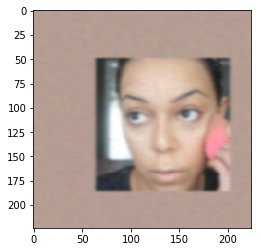

In [4]:
for i, bat in enumerate(db_load, 0):
    img, emo = bat[0], bat[1]
    break

img_np = img.permute(0,2,3,1).numpy()
idx = 0
plt.imshow(img_np[idx])
print emo2txt(emo[idx].nonzero()[0][0])
